In [16]:
import os
import shutil
import random
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score


In [2]:
DATASET_PATH = r"C:\Users\VARAD\OneDrive\Desktop\AIML-Project\END-END-ML\archive\plantvillage dataset\segmented"

OUTPUT_PATH = r"C:\Users\VARAD\OneDrive\Desktop\AIML-Project\END-END-ML\archive"

TRAIN_DIR = os.path.join(OUTPUT_PATH, "train")
VAL_DIR = os.path.join(OUTPUT_PATH, "val")

os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(VAL_DIR, exist_ok=True)
train_ratio = 0.8
random.seed(42)

# for class_name in os.listdir(DATASET_PATH):
#     class_path = os.path.join(DATASET_PATH, class_name)

#     if not os.path.isdir(class_path):
#         continue

#     images = os.listdir(class_path)
#     random.shuffle(images)

#     split_index = int(len(images) * train_ratio)

#     train_images = images[:split_index]
#     val_images = images[split_index:]

#     os.makedirs(os.path.join(TRAIN_DIR, class_name), exist_ok=True)
#     os.makedirs(os.path.join(VAL_DIR, class_name), exist_ok=True)

#     for img in train_images:
#         src = os.path.join(class_path, img)
#         dst = os.path.join(TRAIN_DIR, class_name, img)
#         shutil.copy(src, dst)

#     for img in val_images:
#         src = os.path.join(class_path, img)
#         dst = os.path.join(VAL_DIR, class_name, img)
#         shutil.copy(src, dst)

from torchvision import datasets

train_dataset = datasets.ImageFolder(TRAIN_DIR)
val_dataset = datasets.ImageFolder(VAL_DIR)

print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))
print("Number of classes:", len(train_dataset.classes))


Train samples: 43430
Validation samples: 10876
Number of classes: 38


In [3]:
# Parameters

train_dir = TRAIN_DIR
val_dir = VAL_DIR


img_size = 224
batch_size = 32
num_classes = 38
epochs_cnn = 10
epochs_tl = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)


cuda


In [4]:
# Data Processing

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [5]:
# Data Imbalnce 

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

class_counts = np.bincount(train_dataset.targets)
class_weights = 1.0 / class_counts
sample_weights = class_weights[train_dataset.targets]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



In [6]:
# Model A Simple CNN

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


In [7]:
cnn_model = SimpleCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)


In [8]:
#  Training Loop 

def train_model(model, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs} Loss {total_loss:.4f}")


In [18]:
train_model(cnn_model, optimizer, epochs_cnn)


Epoch 1/10 Loss 2123.4633
Epoch 2/10 Loss 921.4055
Epoch 3/10 Loss 710.2227
Epoch 4/10 Loss 594.3685
Epoch 5/10 Loss 549.4585
Epoch 6/10 Loss 469.2619
Epoch 7/10 Loss 434.2265
Epoch 8/10 Loss 370.1628
Epoch 9/10 Loss 368.6053
Epoch 10/10 Loss 331.1077


In [ ]:
cnn_model_path = r"C:\Users\VARAD\OneDrive\Desktop\AIML-Project\END-END-ML\archive/simple_cnn.pth"

torch.save({
    "model_state_dict": cnn_model.state_dict(),
    "num_classes": num_classes
}, cnn_model_path)

print("Simple CNN model saved")


Simple CNN model saved


In [9]:
# Model B Transfer Learning MobileNetV2

tl_model = models.mobilenet_v2(weights="IMAGENET1K_V1")

for param in tl_model.features.parameters():
    param.requires_grad = False

tl_model.classifier[1] = nn.Linear(
    tl_model.classifier[1].in_features,
    num_classes
)

tl_model = tl_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(tl_model.classifier.parameters(), lr=1e-3)


In [10]:
train_model(tl_model, optimizer, epochs_tl)


Epoch 1/5 Loss 652.7553
Epoch 2/5 Loss 315.3273
Epoch 3/5 Loss 285.2778
Epoch 4/5 Loss 278.1621
Epoch 5/5 Loss 256.6499


In [11]:
for param in tl_model.features[-4:].parameters():
    param.requires_grad = True

optimizer = optim.Adam(tl_model.parameters(), lr=1e-5)
train_model(tl_model, optimizer, 5)


Epoch 1/5 Loss 192.7547
Epoch 2/5 Loss 151.2531
Epoch 3/5 Loss 130.6488
Epoch 4/5 Loss 119.2927
Epoch 5/5 Loss 104.5025


In [13]:
tl_model_path = r"C:\Users\VARAD\OneDrive\Desktop\AIML-Project\END-END-ML\archive/transfer_learning.pth"

torch.save({
    "model_state_dict": tl_model.state_dict(),
    "num_classes": num_classes
}, tl_model_path)

print("Transfer learning model saved")


Transfer learning model saved


In [23]:
cnn_model_path = r"C:\Users\VARAD\OneDrive\Desktop\AIML-Project\END-END-ML\archive/simple_cnn.pth"
cnn_model = SimpleCNN(num_classes=num_classes)  # exact same class
cnn_model = cnn_model.to(device)

checkpoint = torch.load(cnn_model_path, map_location=device)

cnn_model.load_state_dict(checkpoint["model_state_dict"])

print("Loaded model with classes:", checkpoint["num_classes"])


Loaded model with classes: 38


Accuracy: 88.13%

Evaluation Results for simpleCNN

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     0.9043    0.8254    0.8631       126
                                 Apple___Black_rot     0.7439    0.9760    0.8443       125
                          Apple___Cedar_apple_rust     0.8525    0.9455    0.8966        55
                                   Apple___healthy     0.7280    0.8784    0.7961       329
                               Blueberry___healthy     0.7968    0.9900    0.8830       301
          Cherry_(including_sour)___Powdery_mildew     0.9947    0.8957    0.9426       211
                 Cherry_(including_sour)___healthy     0.9816    0.9357    0.9581       171
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.8659    0.6893    0.7676       103
                       Corn_(maize)___Common_rust_     0.9781    0.9331    0.9550       239
               Corn_(maize)

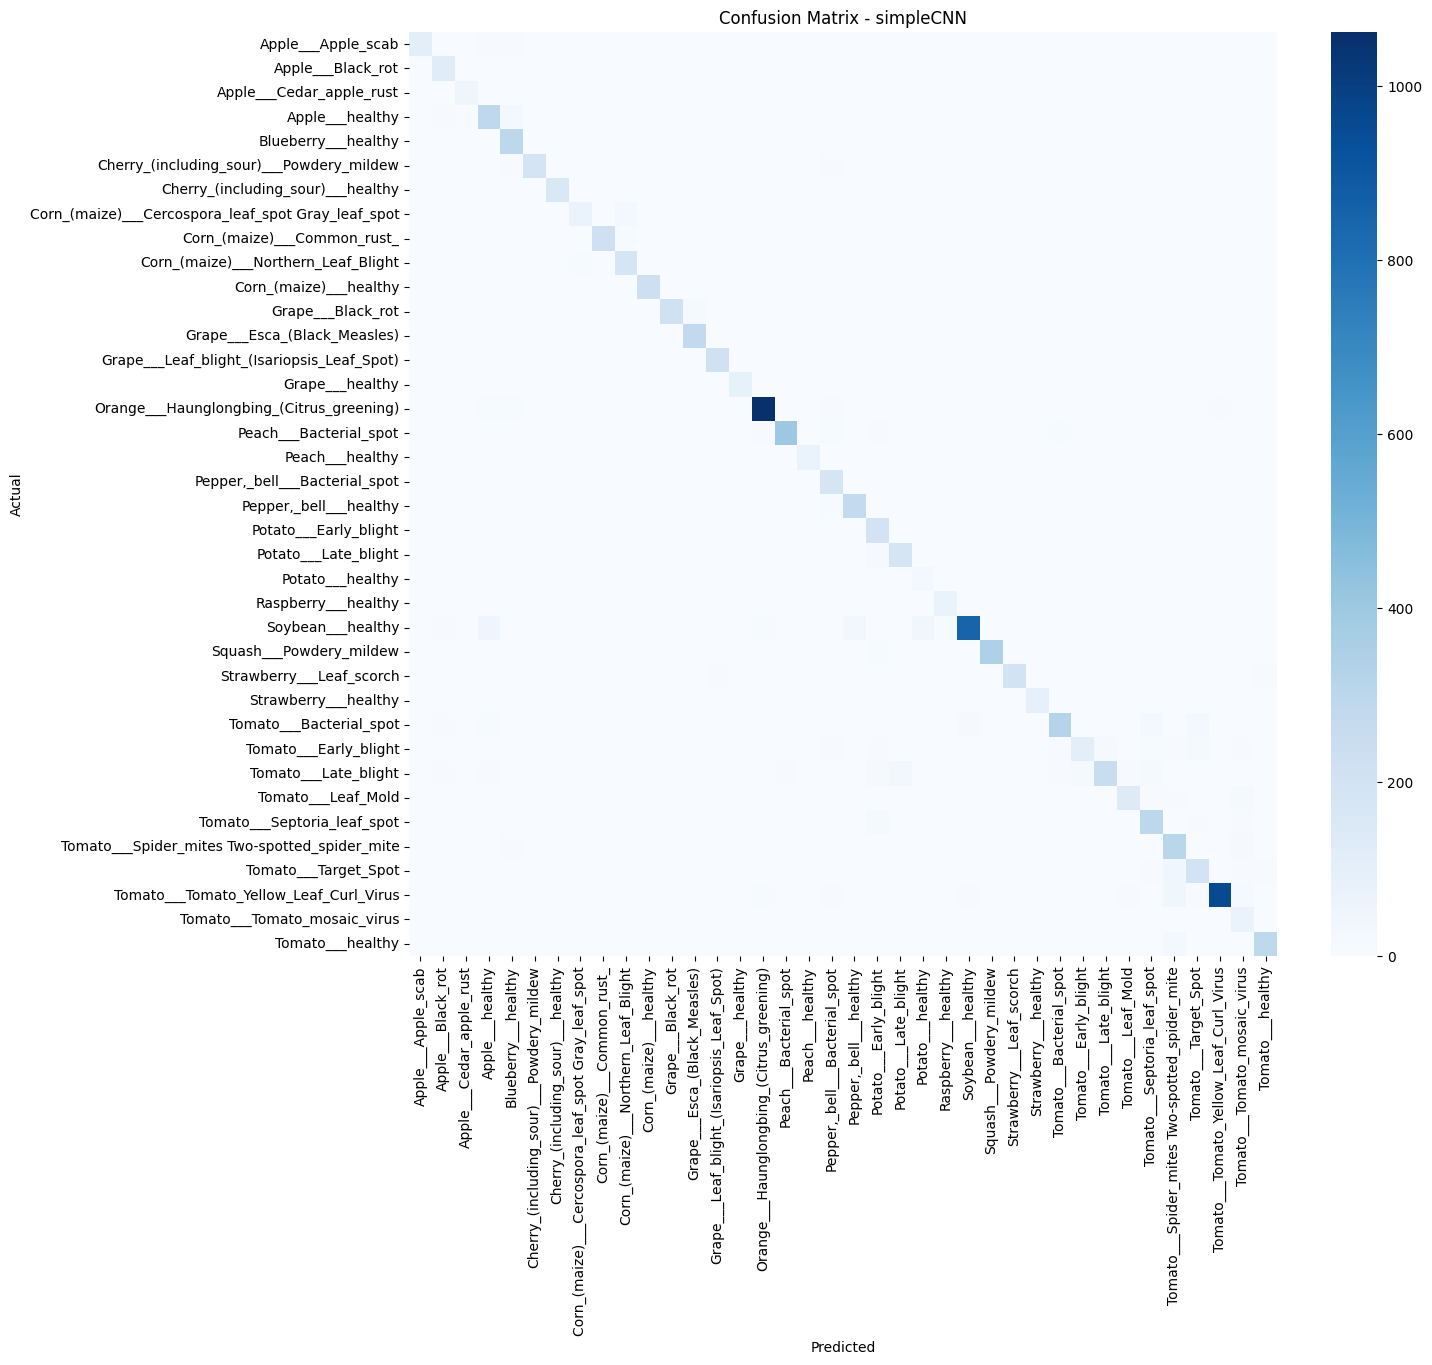

In [24]:
# Evalution of cnn 

model=cnn_model
model_name = "simpleCNN"
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.numpy())

   

    # Calculate accuracy
accuracy = accuracy_score(y_true, y_pred) * 100

print(f"Accuracy: {accuracy:.2f}%")


print(f"\nEvaluation Results for {model_name}\n")
print(classification_report(
        y_true,
        y_pred,
        target_names=val_dataset.classes,
        digits=4
    ))


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(
        cm,
        cmap="Blues",
        xticklabels=val_dataset.classes,
        yticklabels=val_dataset.classes
    )
plt.title(f"Confusion Matrix - {model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Accuracy: 97.31%

Evaluation Results for Transfer Learning

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     0.9920    0.9841    0.9880       126
                                 Apple___Black_rot     1.0000    0.9920    0.9960       125
                          Apple___Cedar_apple_rust     1.0000    0.9818    0.9908        55
                                   Apple___healthy     0.9733    0.9970    0.9850       329
                               Blueberry___healthy     0.9934    0.9934    0.9934       301
          Cherry_(including_sour)___Powdery_mildew     1.0000    0.9953    0.9976       211
                 Cherry_(including_sour)___healthy     1.0000    0.9883    0.9941       171
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.8866    0.8350    0.8600       103
                       Corn_(maize)___Common_rust_     0.9875    0.9916    0.9896       239
               Corn

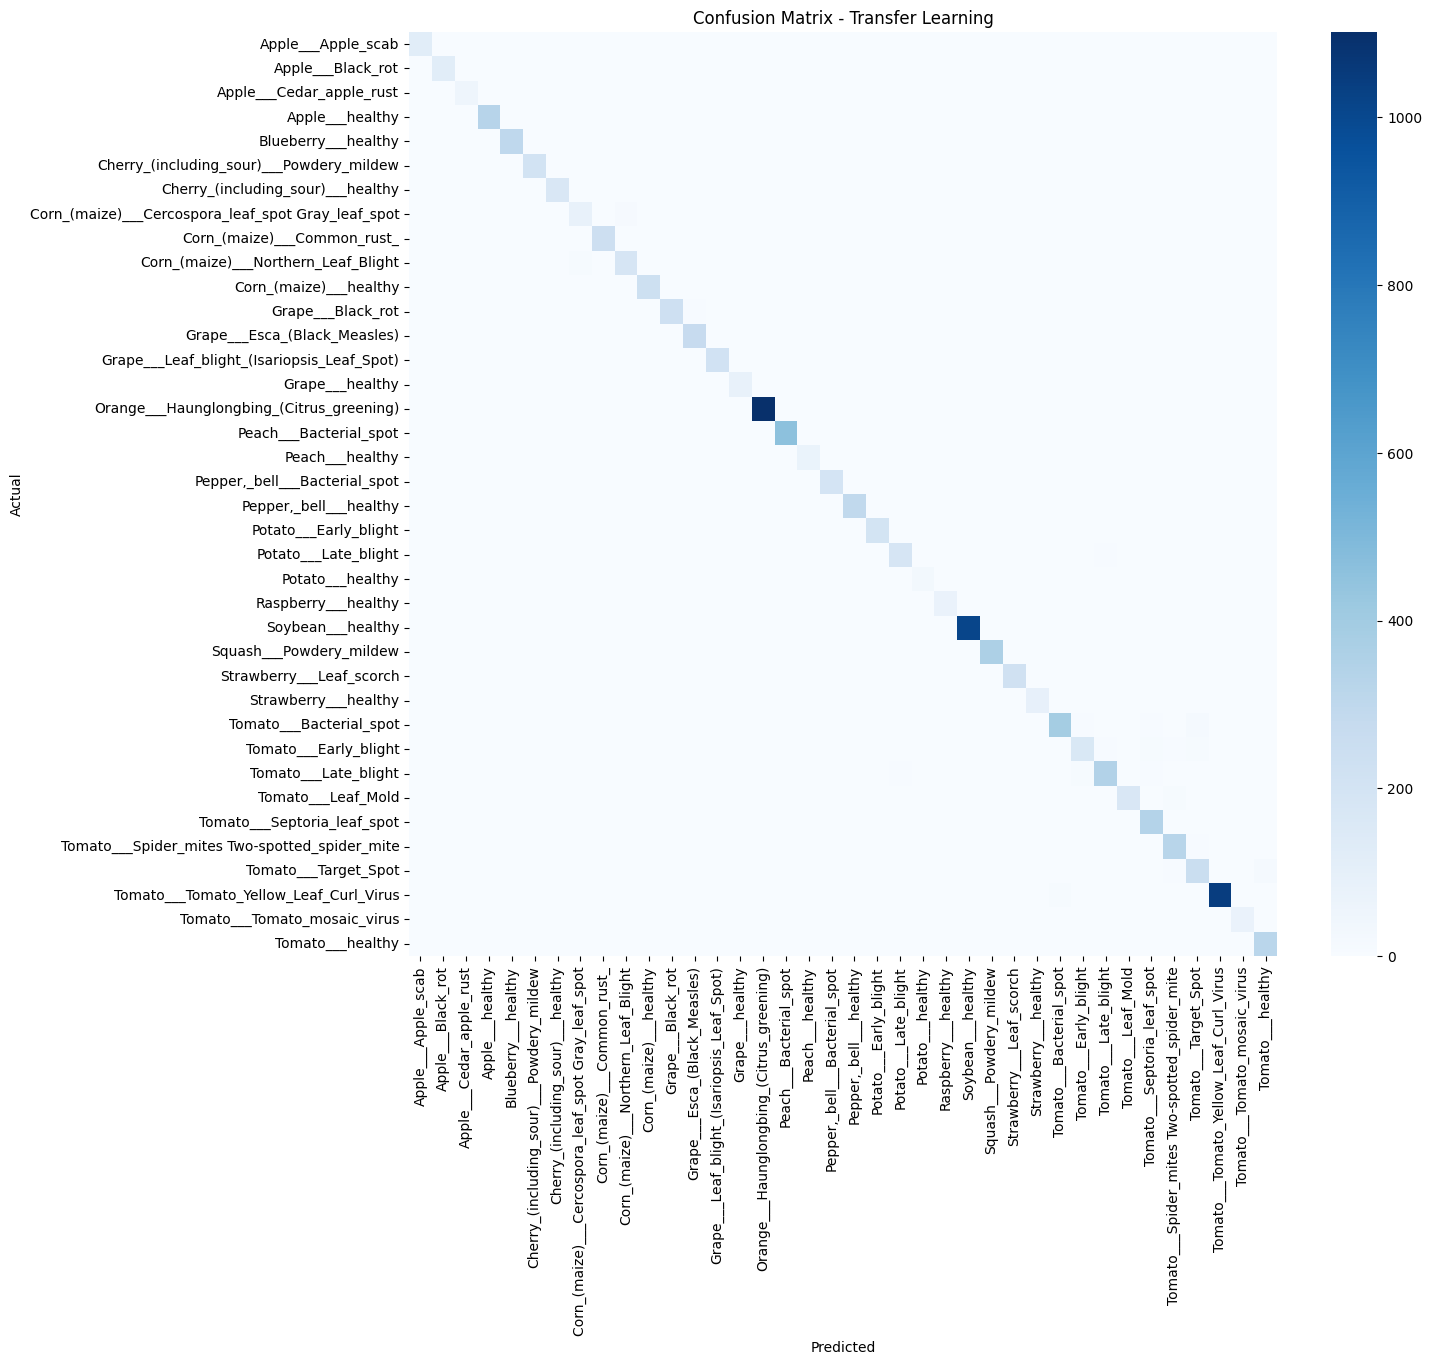

In [21]:
# Evalution of cnn 

model=tl_model
model_name = "Transfer Learning"
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.numpy())

   

    # Calculate accuracy
accuracy = accuracy_score(y_true, y_pred) * 100

print(f"Accuracy: {accuracy:.2f}%")


print(f"\nEvaluation Results for {model_name}\n")
print(classification_report(
        y_true,
        y_pred,
        target_names=val_dataset.classes,
        digits=4
    ))


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(
        cm,
        cmap="Blues",
        xticklabels=val_dataset.classes,
        yticklabels=val_dataset.classes
    )
plt.title(f"Confusion Matrix - {model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



In [ ]:
num_classes = cm.shape[0]
total_samples = np.sum(cm)

print("\nPer-class True Positives (TP) and True Negatives (TN):\n")

for i, class_name in enumerate(val_dataset.classes):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = total_samples - (TP + FP + FN)

    print(f"Class: {class_name}")
    print(f"  TP: {TP}")
    print(f"  TN: {TN}")
    print(f"  FP: {FP}")
    print(f"  FN: {FN}")
    print("-" * 40)


Per-class True Positives (TP) and True Negatives (TN):

Class: Apple___Apple_scab
  TP: 104
  TN: 10739
  FP: 11
  FN: 22
----------------------------------------
Class: Apple___Black_rot
  TP: 122
  TN: 10709
  FP: 42
  FN: 3
----------------------------------------
Class: Apple___Cedar_apple_rust
  TP: 52
  TN: 10812
  FP: 9
  FN: 3
----------------------------------------
Class: Apple___healthy
  TP: 289
  TN: 10439
  FP: 108
  FN: 40
----------------------------------------
Class: Blueberry___healthy
  TP: 298
  TN: 10499
  FP: 76
  FN: 3
----------------------------------------
Class: Cherry_(including_sour)___Powdery_mildew
  TP: 189
  TN: 10664
  FP: 1
  FN: 22
----------------------------------------
Class: Cherry_(including_sour)___healthy
  TP: 160
  TN: 10702
  FP: 3
  FN: 11
----------------------------------------
Class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
  TP: 71
  TN: 10762
  FP: 11
  FN: 32
----------------------------------------
Class: Corn_(maize)___

In [ ]:
import numpy as np

# Total samples
total_samples = np.sum(cm)

# Total True Positives (correct predictions)
TP_total = np.trace(cm)

# Total False Negatives
FN_total = np.sum(cm) - TP_total

# Total False Positives
FP_total = FN_total  # in multiclass single-label classification

# Total True Negatives
TN_total = (total_samples * (cm.shape[0] - 1)) - FN_total - FP_total

pr

In [27]:
    print(f"  TP: {TP_total}")
    print(f"  TN: {TN_total}")
    print(f"  FP: {FP_total}")
    print(f"  FN: {FN_total}")

  TP: 9585
  TN: 399830
  FP: 1291
  FN: 1291
